# Fine-tuning a masked language model (PyTorch)

For many NLP applications involving Transformer models, you can simply take a pretrained model from the Hugging Face Hub and fine-tune it directly on your data for the task at hand. Provided that the corpus used for pretraining is not too different from the corpus used for fine-tuning, transfer learning will usually produce good results.

However, there are a few cases where you’ll want to first fine-tune the language models on your data, before training a task-specific head. For example, if your dataset contains legal contracts or scientific articles, a vanilla Transformer model like BERT will typically treat the domain-specific words in your corpus as rare tokens, and the resulting performance may be less than satisfactory. By fine-tuning the language model on in-domain data you can boost the performance of many downstream tasks, which means you usually only have to do this step once!

This process of fine-tuning a pretrained language model on in-domain data is usually called domain adaptation. It was popularized in 2018 by ULMFiT, which was one of the first neural architectures (based on LSTMs) to make transfer learning really work for NLP. An example of domain adaptation with ULMFiT is shown in the image below; in this section we’ll do something similar, but with a Transformer instead of an LSTM!



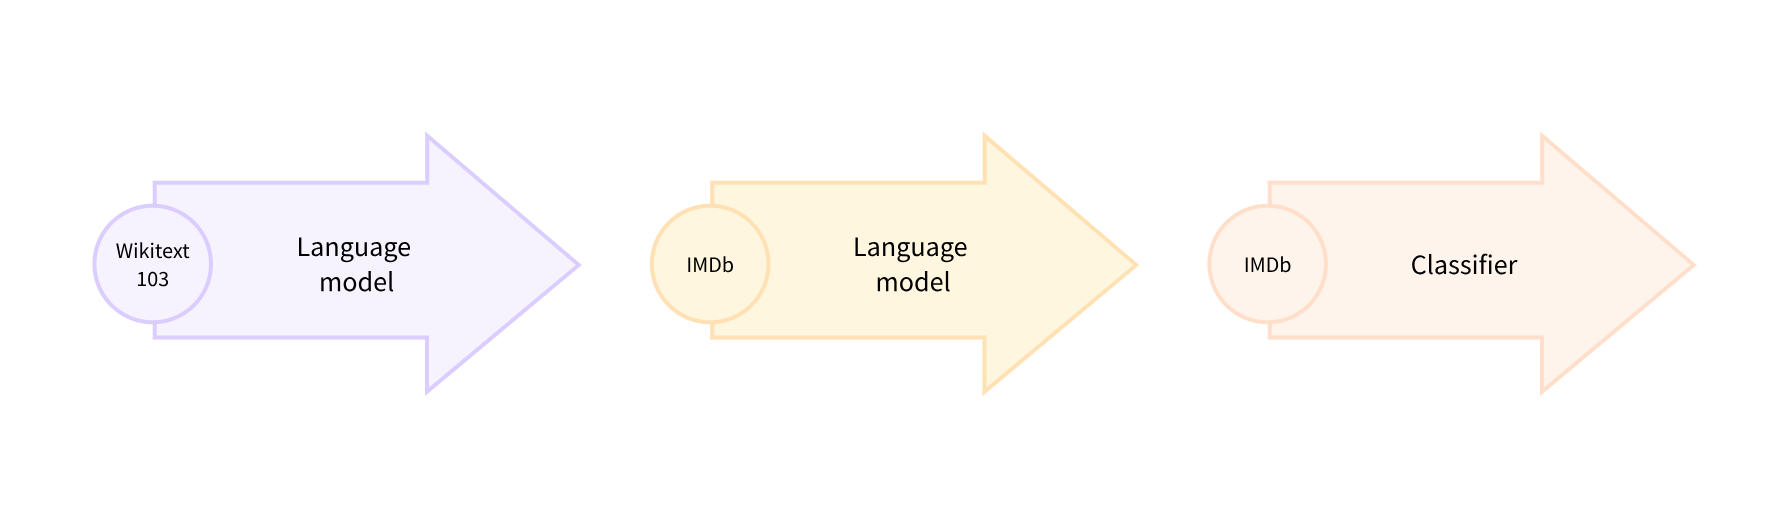

By the end of this section you’ll have a masked language model on the Hub that can autocomplete sentences as shown below:



Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "josteece@googlemail.com"
!git config --global user.name "Josteece"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [ ]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'

In [ ]:
text = "This is a great [MASK]."

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: This is your typical Priyadarshan movie--a bunch of loony characters out on some silly mission. His signature climax has the entire cast of the film coming together and fighting each other in some crazy moshpit over hidden money. Whether it is a winning lottery ticket in Malamaal Weekly, black money in Hera Pheri, "kodokoo" in Phir Hera Pheri, etc., etc., the director is becoming ridiculously predictable. Don\'t get me wrong; as clichéd and preposterous his movies may be, I usually end up enjoying the comedy. However, in most his previous movies there has actually been some good humor, (Hungama and Hera Pheri being noteworthy ones). Now, the hilarity of his films is fading as he is using the same formula over and over again.<br /><br />Songs are good. Tanushree Datta looks awesome. Rajpal Yadav is irritating, and Tusshar is not a whole lot better. Kunal Khemu is OK, and Sharman Joshi is the best.'
'>>> Label: 0'

'>>> Review: Okay, the story makes no sense, the characters

In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 50000
    })
})

In [ ]:
tokenizer.model_max_length

512

In [ ]:
chunk_size = 128

In [ ]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 200'
'>>> Review 1 length: 559'
'>>> Review 2 length: 192'

In [ ]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 951'

In [ ]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 55'

In [ ]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 61289
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 59905
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 122963
    })
})

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

".... at.......... high. a classic line : inspector : i'm here to sack one of your teachers. student : welcome to bromwell high. i expect that many adults of my age think that bromwell high is far fetched. what a pity that it isn't! [SEP] [CLS] homelessness ( or houselessness as george carlin stated ) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. most people think of the homeless"

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

In [ ]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

'>>> [CLS] bromwell high is a cartoon comedy [MASK] it ran at the same time as some other programs about school life, such as " teachers ". my 35 years in the teaching profession lead me to believe that bromwell high\'s satire is much closer to reality than is " teachers ". the scramble to survive financially, the insightful students who can see right through their pathetic teachers\'pomp, the pettiness of the whole situation, all remind me of the schools i knew and their students. when i saw the episode in which a student repeatedly tried to burn down the school, i immediately recalled.....'

'>>> .... [MASK] [MASK] [MASK] [MASK]....... high. a classic line : inspector : i\'m here to sack one of your teachers. student : welcome to bromwell high. i expect that many adults of my age think that bromwell high is far fetched. what a pity that it isn\'t! [SEP] [CLS] homelessness ( or houselessness as george carlin stated ) has been an issue for years but never a plan to help those on the st

In [ ]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 1000
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 21.75

In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 11.32

In [ ]:
trainer.push_to_hub()

In [ ]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [ ]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "distilbert-base-uncased-finetuned-imdb-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'lewtun/distilbert-base-uncased-finetuned-imdb-accelerate'

In [ ]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

>>> Epoch 0: Perplexity: 11.397545307900472
>>> Epoch 1: Perplexity: 10.904909330983092
>>> Epoch 2: Perplexity: 10.729503505340409

In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="huggingface-course/distilbert-base-uncased-finetuned-imdb"
)

In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

'>>> this is a great movie.'
'>>> this is a great film.'
'>>> this is a great story.'
'>>> this is a great movies.'
'>>> this is a great character.'